In [1]:
from billiard import *

In [2]:
QC = Billiard(shape='quartercircle', a1=1, a2=1, M0=400, V0=5e4)
QC.compute_everything()

V-matrix Imported


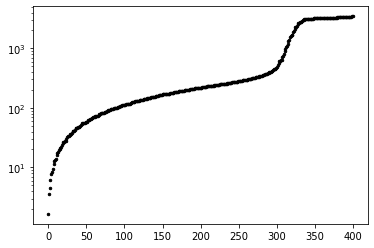

In [3]:
QC.plot_e_energies(log=True)

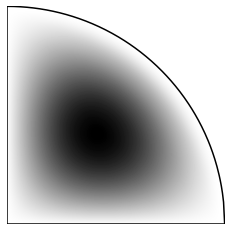

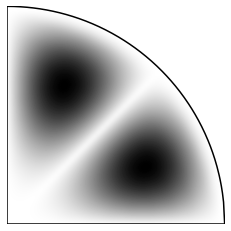

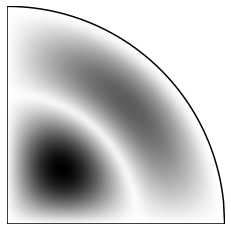

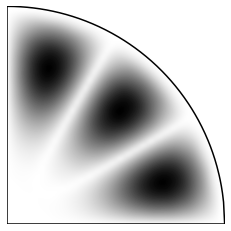

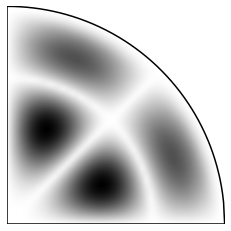

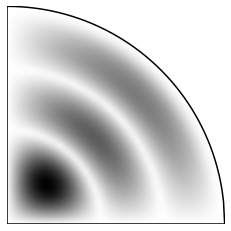

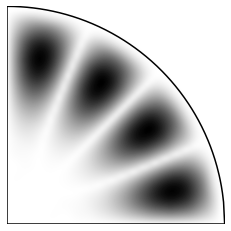

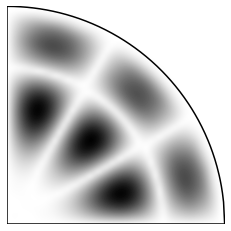

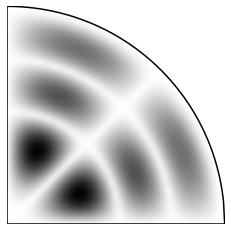

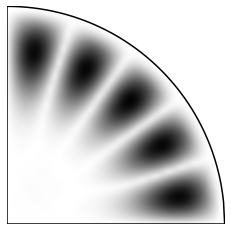

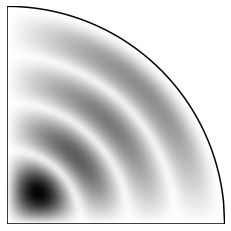

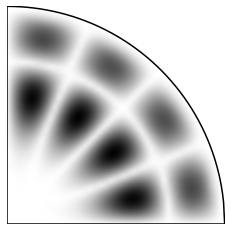

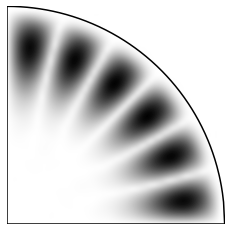

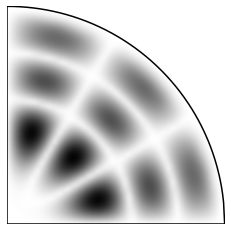

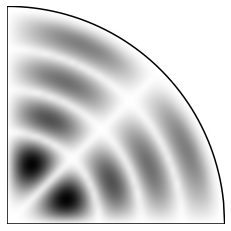

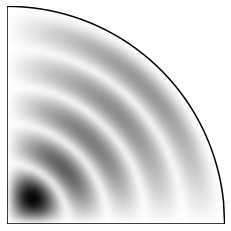

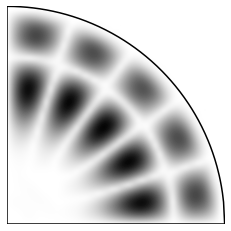

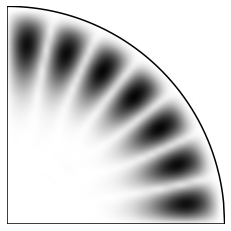

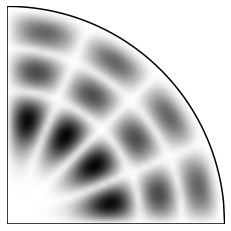

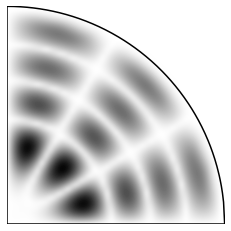

In [4]:
for i in range(20):
    QC.plot_wavefunction(i, 50, 50, save=True)

In [9]:
def nE(Emax, E_list):
    # Returns count of entries in E_list smaller or equal to Emax
    count = 0
    for E in E_list:
        if E <= Emax:
            count += 1

    return count

def diff(E_list):
    return [(E_list[n+1] - E_list[n]) for n in range(0, len(E_list)-1)]

evals = QC.En_evals
#sorted(evals)

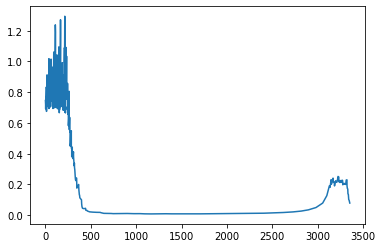

In [10]:
# want to estimate spectral density... calculate average spacing between 2 nearest neighbours on either side -> space between 5 consecutive energy levels... take this as rho

# spectral density is how many energy levels appear per unit of energy
davg = 10
rho = [(davg-1)/(evals[i+davg] - evals[i]) for i in range(len(evals)-davg) ]
plt.plot(evals[:400-davg], rho)
#nE(rho)
#plt.plot(diff([nE(rho[i],rho) for i, _ in enumerate(evals[:400-davg])]))
#diff([nE(rho[i], rho) for i, E in enumerate(evals[:100])])
#plt.plot([sum([rho[0]]) for E in evals])

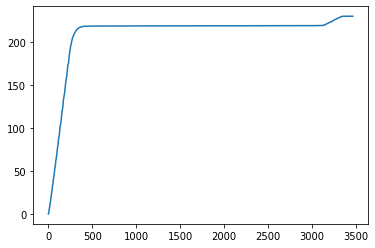

In [11]:
e_unfolded = [sum(rho[0:i]) for i, E in enumerate(evals)]
plt.plot(evals, e_unfolded)
#plt.plot(range(3500),[1/(4*np.pi)* (QC.A*E - QC.L*np.sqrt(E)) for E in range(3500)])
#plt.xlim([0,400])
#plt.ylim([0,500])

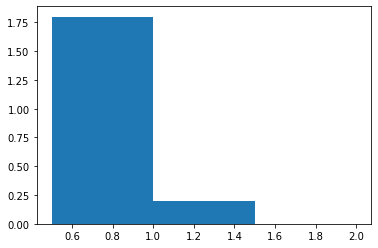

In [12]:
num_bins=15
plt.hist(np.sort(diff(e_unfolded[:200])), bins=[0.5,1, 1.5, 2], density=True)

Pgoe = lambda s: np.pi/2 * s * np.exp(-np.pi * s**2 / 4)

S = np.linspace(0, 1.5, 100)

#plt.plot(S, [Pgoe(s) for s in S])

# Circle

In [6]:
from billiard import *

In [7]:
C = Billiard(shape='circle', a1=2, a2=2, M0=800, V0=5e4)
C.compute_everything()

V-matrix Imported


In [8]:
sorted(C.kn_evals[:20])

[2.396585398357897,
 3.8182923912024793,
 3.8191871842449534,
 5.117272842848917,
 5.119061055165009,
 5.501339195699762,
 6.357920451747103,
 6.359604880020435,
 6.991337419260748,
 6.99300099411772,
 7.560734671353997,
 7.564865892433171,
 8.387454051865877,
 8.390797345116434,
 8.624864947008115,
 8.742188770941887,
 8.74275620970203,
 9.727686449309386,
 9.7303103745437,
 9.898484714961993]

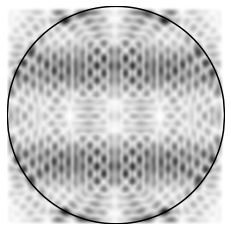

In [34]:
#for i in range(20):
#    C.plot_wavefunction(i, 50, 50, save=True)
C.plot_wavefunction(519, 50, 50, save=True)

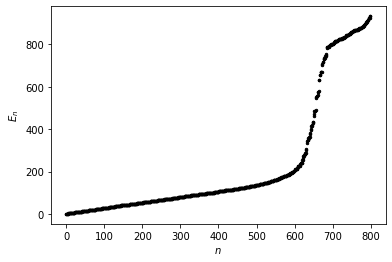

In [39]:
plt.scatter(range(len(C.En_evals)), C.En_evals, s=6, color="black")
#plt.yscale("log")
plt.ylabel(r"$E_n$")
plt.xlabel(r"$n$")

plt.savefig("circle_evals_800.png", dpi=200, bbox_inches="tight")
plt.show()


# STADIUM

In [1]:
from billiard import *

In [2]:
S = Billiard(shape='stadium', a1=4, a2=2, M0=400, V0=5e4)
S.compute_everything()

V-matrix Imported


In [3]:
S.En_evals[:20]

array([0.11297329, 0.18789358, 0.3100859 , 0.3803107 , 0.46835908,
       0.47541578, 0.61010254, 0.6811165 , 0.80065816, 0.82273004,
       0.89879152, 0.94872601, 1.03055641, 1.07237685, 1.22221072,
       1.289935  , 1.29575078, 1.43690095, 1.5434314 , 1.54863605])

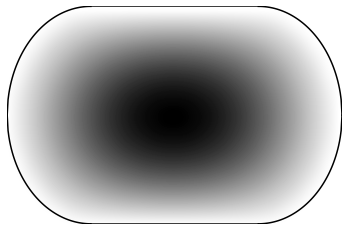

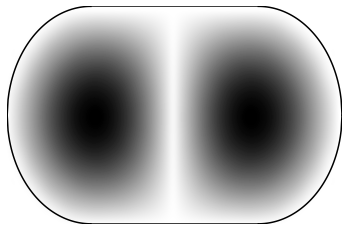

KeyboardInterrupt: 

In [4]:
for n in range(20):
    S.plot_wavefunction(n, 2*50, 50, save=True)